<a href="https://colab.research.google.com/github/alexamgreat/Conser-vision-Practice-Area-Image-Classification-MobileNetV2-Model/blob/main/Conser_vision_Practice_Area_Image_Classification_MobileNetV2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import tensorflow_hub
print("TF version, tf-hub version")
print(tf.__version__)
print(tensorflow_hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
import pandas as pd
import numpy as np

TF version, tf-hub version
2.18.0
0.16.1
GPU is available


In [1]:
#unzip images from train features
#!unzip "/content/drive/MyDrive/Conser-vision Practice Area: Image Classification/train_features.zip" -d "/content/train_features"

In [18]:
!ls /content/train_features

train_features


In [19]:
train_features= pd.read_csv("drive/MyDrive/Conser-vision Practice Area: Image Classification/train_features.csv")
train_features.head()

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036


In [20]:
train_labels= pd.read_csv("drive/MyDrive/Conser-vision Practice Area: Image Classification/train_labels.csv")
train_labels.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
import os
#Verify Image Files
image_dir = "/content/train_features/train_features"
# Count images
image_count = len([f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
print(f"🔍 Total images found: {image_count}")


🔍 Total images found: 16488


In [22]:
#viewing how many classes we have

# Drop the 'id' column (it is not a class label)
class_counts = train_labels.drop(columns=["id"]).sum()

# Print unique classes and their counts
print("\n📌 Unique Classes:", list(class_counts.index))
print("\n📌 Class Distribution:")
print(class_counts)



📌 Unique Classes: ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

📌 Class Distribution:
antelope_duiker     2474.0
bird                1641.0
blank               2213.0
civet_genet         2423.0
hog                  978.0
leopard             2254.0
monkey_prosimian    2492.0
rodent              2013.0
dtype: float64


In [23]:
#Convert one-hot encoded labels into a single "label" column
class_names = train_labels.columns[1:]  # Exclude 'id'
train_labels['label'] = train_labels[class_names].idxmax(axis=1)

# Merge train_features with train_labels using 'id'
train_df = pd.merge(train_features, train_labels[['id', 'label']], on="id")

# Display first few rows to verify
print(train_df.head())


         id                     filepath   site             label
0  ZJ000000  train_features/ZJ000000.jpg  S0120              bird
1  ZJ000001  train_features/ZJ000001.jpg  S0069  monkey_prosimian
2  ZJ000002  train_features/ZJ000002.jpg  S0009              bird
3  ZJ000003  train_features/ZJ000003.jpg  S0008  monkey_prosimian
4  ZJ000004  train_features/ZJ000004.jpg  S0036           leopard


In [24]:
base_dir = "/content/train_features/train_features/"  # Your image directory
train_df["filepath"] = train_df["id"].apply(lambda x: os.path.join(base_dir, x + ".jpg"))  # Assuming .jpg extension

# Check the first few file paths to ensure they're correct
print(train_df["filepath"].head())


0    /content/train_features/train_features/ZJ00000...
1    /content/train_features/train_features/ZJ00000...
2    /content/train_features/train_features/ZJ00000...
3    /content/train_features/train_features/ZJ00000...
4    /content/train_features/train_features/ZJ00000...
Name: filepath, dtype: object


In [25]:
missing_files = train_df[~train_df["filepath"].apply(os.path.exists)]
print(f"Missing files: {len(missing_files)}")


Missing files: 0


Section two.
use a pretrained model

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with rescaling (optional, based on your needs)
datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# Create the training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",   # Column with file paths
    y_col="label",      # Column with labels
    target_size=(224, 224),  # Resize images
    batch_size=32,      # Number of images to return in each batch
    class_mode="categorical",  # Since you have more than 2 classes
    subset="training",  # For the training set
    shuffle=True        # Shuffle images for better training
)

# Create the validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",   # Column with file paths
    y_col="label",      # Column with labels
    target_size=(224, 224),  # Resize images
    batch_size=32,      # Number of images to return in each batch
    class_mode="categorical",  # Since you have more than 2 classes
    subset="validation",  # For the validation set
    shuffle=False       # Don't shuffle validation data
)

Found 13191 validated image filenames belonging to 8 classes.
Found 3297 validated image filenames belonging to 8 classes.


In [27]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(train_generator.class_indices), activation="softmax")(x)

  # Dynamically set output layer

# Compile the model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, History
import matplotlib.pyplot as plt
import os

# Directory to save the best model
model_save_path = "drive/MyDrive/Conser-vision Practice Area: Image Classification.keras"

# Callback to save the model with the best validation accuracy
checkpoint = ModelCheckpoint(
    filepath=model_save_path,   # Save path
    monitor="val_accuracy",     # Monitor validation accuracy
    save_best_only=True,        # Save only the best model
    save_weights_only=False,    # Save full model (architecture + weights)
    mode="max",                 # Maximize validation accuracy
    verbose=1                   # Print when saving
)

# Train the model with checkpointing
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint, History()]  # Include ModelCheckpoint callback
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.3580 - loss: 1.7069
Epoch 1: val_accuracy improved from -inf to 0.47512, saving model to drive/MyDrive/Conser-vision Practice Area: Image Classification.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 229s 532ms/step - accuracy: 0.3581 - loss: 1.7065 - val_accuracy: 0.4751 - val_loss: 1.3782
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4772 - loss: 1.3786
Epoch 2: val_accuracy improved from 0.47512 to 0.52275, saving model to drive/MyDrive/Conser-vision Practice Area: Image Classification.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 217s 527ms/step - accuracy: 0.4773 - loss: 1.3786 - val_accuracy: 0.5228 - val_loss: 1.2815
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.4996 - loss: 1.2994
Epoch 3: val_accuracy improved from 0.52275 to 0.52367, saving model to drive/MyDrive/Conser-vision Practice Area: Image Classification.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 211s 511ms/step - accuracy: 0.4996 - loss:

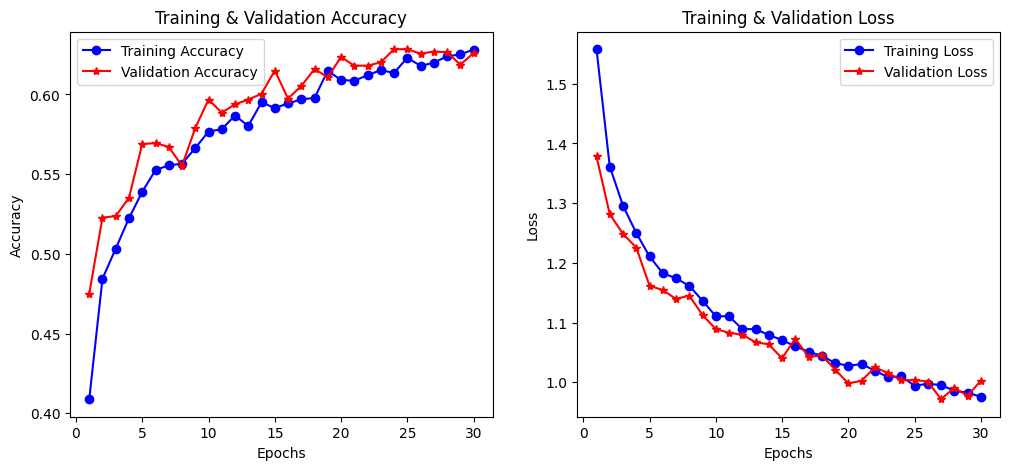

Best model saved at: drive/MyDrive/Conser-vision Practice Area: Image Classification.keras


In [29]:
# Function to plot training curves
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training curves
plot_training_curves(history)

# Print model save location
print(f"Best model saved at: {model_save_path}")

In [31]:
from tensorflow.keras.models import load_model
import pandas as pd

# Load the trained model
best_model = load_model("/content/drive/MyDrive/Conser-vision Practice Area: Image Classification.keras")




Prepare testing data

In [2]:
#!unzip "/content/drive/MyDrive/Conser-vision Practice Area: Image Classification/test_features.zip" -d "/content/test_features"

In [5]:
import pandas as pd

# Load the CSV that contains the test image metadata (paths)
test_df = pd.read_csv('/content/drive/MyDrive/Conser-vision Practice Area: Image Classification/test_features.csv')

# Display the first few rows to understand its structure
print(test_df.head())

         id                    filepath   site
0  ZJ016488  test_features/ZJ016488.jpg  S0082
1  ZJ016489  test_features/ZJ016489.jpg  S0040
2  ZJ016490  test_features/ZJ016490.jpg  S0040
3  ZJ016491  test_features/ZJ016491.jpg  S0041
4  ZJ016492  test_features/ZJ016492.jpg  S0040


In [6]:
import os

# Define the base directory for the test images
base_test_dir = "/content/test_features/test_features/"  # Your test image directory

# Update the 'filepath' column with the correct file paths
test_df["filepath"] = test_df["id"].apply(lambda x: os.path.join(base_test_dir, x + ".jpg"))  # Assuming .jpg extension

# Check the first few file paths to ensure they're correct
print(test_df["filepath"].head())

0    /content/test_features/test_features/ZJ016488.jpg
1    /content/test_features/test_features/ZJ016489.jpg
2    /content/test_features/test_features/ZJ016490.jpg
3    /content/test_features/test_features/ZJ016491.jpg
4    /content/test_features/test_features/ZJ016492.jpg
Name: filepath, dtype: object


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a test data generator (rescale only, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",   # File paths for test images
    y_col=None,         # No labels for test data
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,    # No labels, only images
    shuffle=False       # Preserve order for matching predictions
)


Found 4464 validated image filenames.


In [33]:
import numpy as np

# Predict probabilities for each class
predictions = best_model.predict(test_generator, verbose=1)

# Define class names in the required order
class_names = [
    "antelope_duiker", "bird", "blank", "civet_genet",
    "hog", "leopard", "monkey_prosimian", "rodent"
]

# Construct DataFrame with IDs and prediction probabilities
results = pd.DataFrame(predictions, columns=class_names)
results.insert(0, 'id', test_df['id'])  # Insert 'id' as the first column

# Save predictions to CSV
results.to_csv("predictions.csv", index=False)

print("✅ Predictions saved to predictions.csv!")


140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step
✅ Predictions saved to predictions.csv!
